# Imports

In [1]:
import sys
sys.path.insert(1, '../')
from genesis import *

C:\Users\vin_s\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
universe = G10_FX
total_returns = total_returns_usd[universe]
spot_returns = spot_returns_usd[universe]
carry_returns = carry_returns_usd[universe]

# Settings

In [3]:
settings = Settings(start_date = "2000-01-01", end_date = "2016-12-31", notional = 100, implementation_lag = 1,
             asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=126, rebalance_period="daily",
             sector_scaling_method="simple", sector_scaling_target=None, sector_scaling_width=126,
             portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=252)

In [4]:
fwd = ['EUR1M CMPN Curncy', 'GBP1M CMPN Curncy', 'AUD1M CMPN Curncy', 
       'NZD1M CMPN Curncy', 'JPY1M CMPN Curncy', 'CAD1M CMPN Curncy', 
       'SEK1M CMPN Curncy', 'NOK1M CMPN Curncy', 'CHF1M CMPN Curncy']

fwd_scale_g10 = {"EURUSD": 10000,
             "GBPUSD" : 10000,
             "AUDUSD" : 10000,
             "NZDUSD" : 10000,
             "USDJPY" : 100,
             "USDCAD" : 10000,
             "USDSEK" : 10000,
             "USDNOK" : 10000,
             "USDCHF" : 10000}

fwd_data = new_raw_data[fwd].pipe(fill_date, fill_forward=True)
fwd_data.columns = fwd_scale_g10.keys()
for c in fwd_scale_g10.keys():
  fwd_data[c] = fwd_data[c]/fwd_scale_g10[c]
  
fwd_price_ori = spot_price_ori[fwd_scale_g10.keys()] + fwd_data

In [5]:
rx = fwd_price_ori.pipe(standardize_series, "prices").pipe(np.log10).shift(1) - \
    spot_price_ori[fwd_scale_g10.keys()].pipe(standardize_series, "prices").pipe(np.log10)

In [6]:
def rsv(x):
  mean = x.mean()
  rvu = sum([x**2 for x in x if x > mean])
  rvd = sum([x**2 for x in x if x <= mean])
  return rvu - rvd

In [ ]:
pos = (rx > rx.pipe(demean, 21)).astype(int)
neg = (rx < rx.pipe(demean, 21)).astype(int)

rvu = ((rx**2)*pos)
rvd = ((rx**2)*neg)

rsv = rvu.rolling(21).sum() - rvd.rolling(21).sum()
sig = rsv.pipe(demean_xs).pipe(cap_helper, 0.00002).pipe(rolling_mean, 5) * -1
#CAP or NO CAP

In [7]:
rsv_signal = rx.groupby(rx.index.strftime('%Y-%m')).agg([rsv])
rsv_signal.columns = [x[0] for x in rsv_signal.columns]
rsv_signal.index = rx.loc[rx.groupby(rx.index.to_period('M')).apply(lambda x: x.index.max())].index

In [8]:
sig = rsv_signal.pipe(fill_date, True).pipe(demean_xs).pipe(cap_helper, 0.00025)

In [ ]:
rx2 = rx**2

In [ ]:
rxi = rx.index
ai = []
for i in rx.index.strftime('%Y-%m').unique():
  aa = [x for x in rxi if x.strftime("%Y-%m") == i][0]
  ai.append(aa)

In [ ]:
rx_mo = rx.groupby(rx.index.strftime('%Y-%m')).mean()
rx_mo.index = ai

In [ ]:
pos = (rx.loc[:"2020"] > rx_mo.pipe(fill_date, fill_forward=True).loc[:"2020"]).astype(int)
neg = (rx.loc[:"2020"] <= rx_mo.pipe(fill_date, fill_forward=True).loc[:"2020"]).astype(int)

rvu = (rx2*pos)
rvd = (rx2*neg)

In [ ]:
rsv = rvd.groupby(rvu.index.strftime('%Y-%m')).sum() - rvu.groupby(rvu.index.strftime('%Y-%m')).sum()
rsv.index = ai
rsv = rsv.shift(1)
rsv = rsv.pipe(fill_date, fill_forward=True)

In [ ]:
sig = rsv.pipe(demean_xs).pipe(cap_helper, 0.00025)

# Signal

In [19]:
b = Backtest(signal = sig*-1, asset_returns = total_returns, tcost = abs(total_returns*0), settings = settings, settings_inject={"rebalance_period":"daily"})
b.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [20]:
bt_obj = b

In [21]:
get_summary(bt_obj)

Returns   : 0.03625587591944259
Vol       : 0.11462418273264446
SR        : 0.3163021541798708
Max DD    : -41.56

C Returns : 0.030094001028630402
C SR      : 0.21254222233852021
C Max DD  : -35.53

Hit rate  : 0.531
W | N | L : 0.53 | 0.0 | 0.47
W/L Ratio : 1.13


In [22]:
get_returns_stats(bt_obj.asset_rtn.loc["2003":], b.wts.loc["2003":])

,USDAUD,USDCAD,USDEUR,USDGBP,USDJPY,USDNZD,USDSEK,USDNOK,USDCHF
annualized_return,1.910101,-0.359306,0.114684,-0.480083,1.622054,1.430379,0.307001,-0.775106,-1.294048
sharpe,0.402981,-0.155304,0.048865,-0.164916,0.315732,0.247803,0.105544,-0.242412,-0.291484
dollar_sharpe,0.359998,-0.168962,0.037994,-0.177664,0.302284,0.199558,0.093371,-0.258052,-0.310824
trade_sharpe,0.402981,-0.155304,0.048865,-0.164916,0.315732,0.247803,0.105544,-0.242412,-0.291484
long_sharpe,-0.568121,-0.300174,0.055488,-0.393437,0.425091,-1.119975,0.028075,-0.102184,-0.232736
short_sharpe,0.475783,0.07344,0.019391,0.080801,-0.457614,0.303705,0.300821,-0.382431,-1.131695
sortino,0.241414,-0.091068,0.029583,-0.096535,0.197746,0.149676,0.065473,-0.139515,-0.131997
max_drawdown,-10.651198,-7.897219,-12.721854,-10.415669,-16.183727,-18.312482,-10.694895,-18.683989,-23.215031
max_drawdown_start,2007-08-16,2009-01-20,2010-06-07,2007-10-03,2007-07-09,2007-07-24,2005-11-16,2003-05-29,2003-09-02
max_drawdown_end,2008-10-27,2010-08-05,2011-10-03,2016-07-14,2011-11-21,2009-02-09,2011-01-07,2014-11-18,2015-01-15


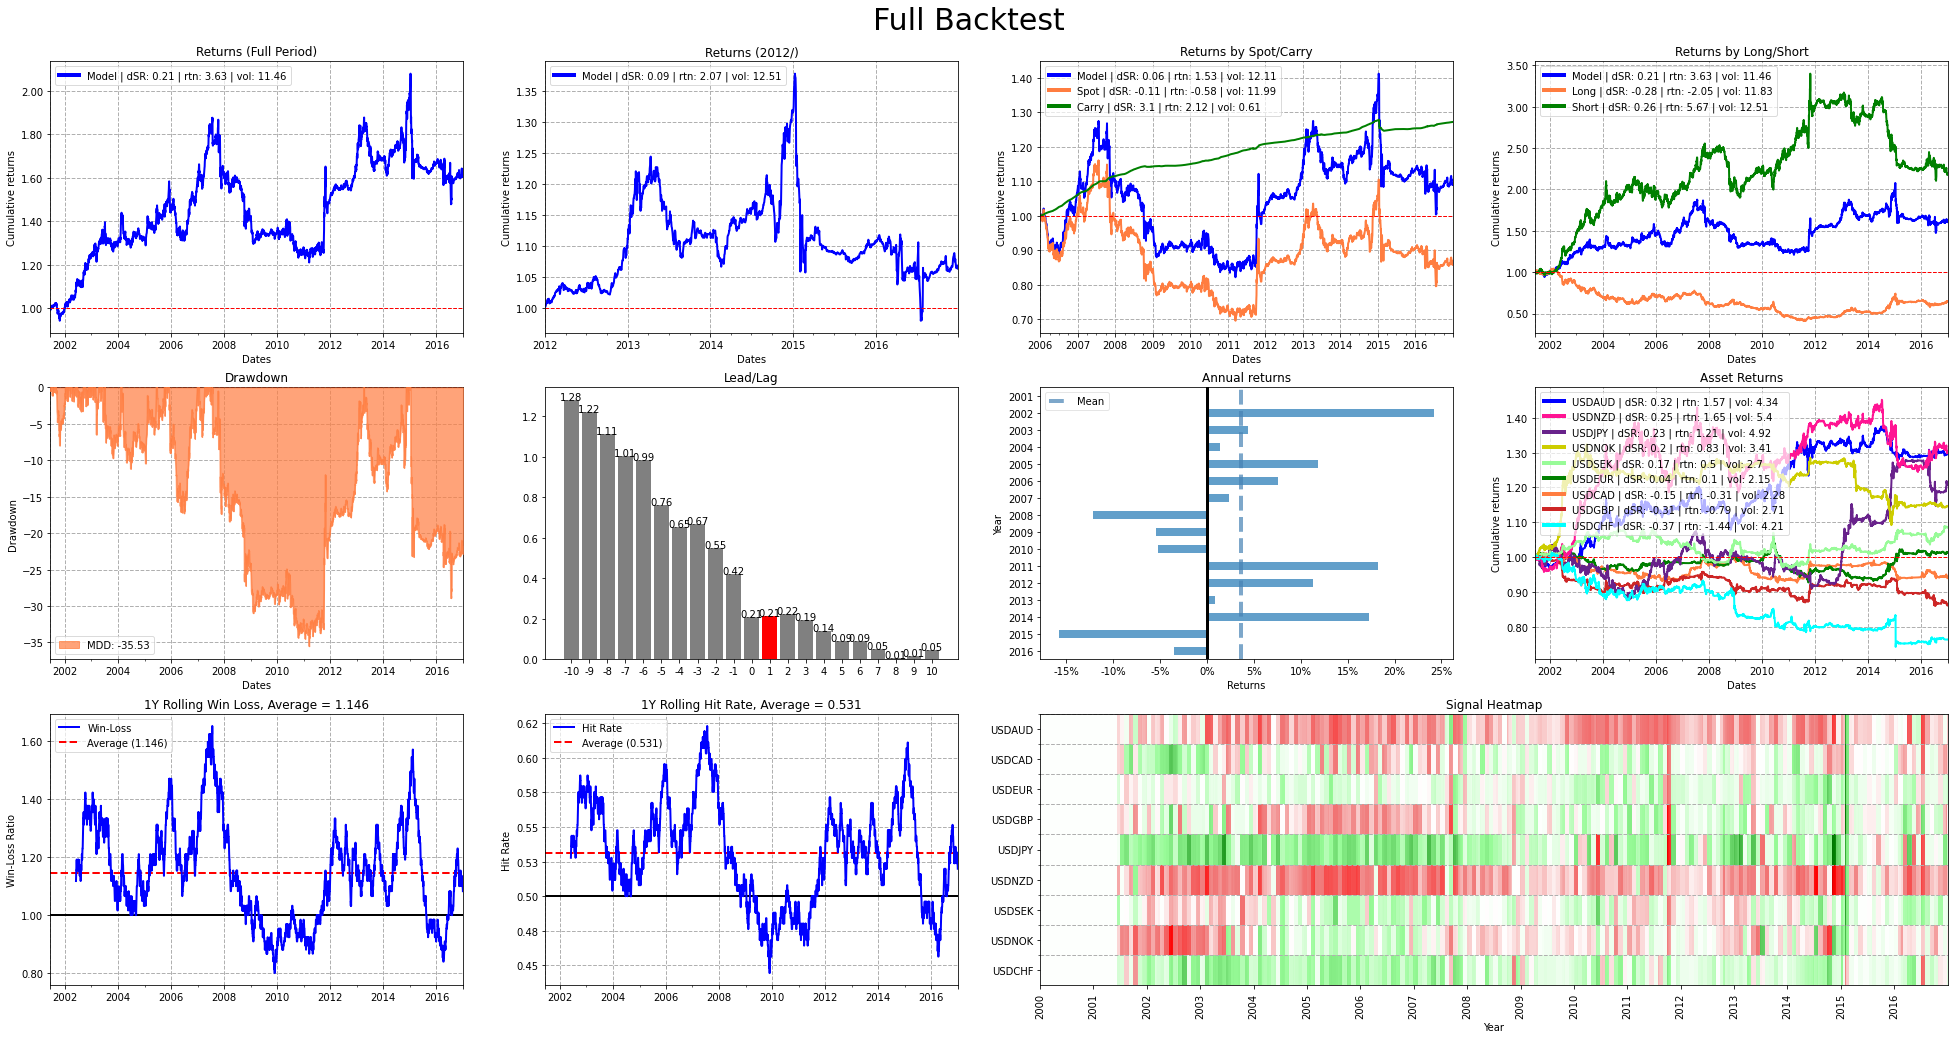

In [23]:
plot_bt(bt_obj)